In [1]:
import mdtraj as md
import glob as glob
from scipy import spatial
from collections import defaultdict
from tqdm import tqdm_notebook
import numpy as np
import os

In [2]:
def hydrophicity_clusterer(files, threshold=0.5, interchain=True, intraresidue=False, 
                           hydrophobicity_map=None, h_threshold=0.0, debug=True):
    
    """
    Function to calculate the number of contacts each residue has hydrophobic and hydrophilic residues.
    As a convention values above h_threshold are considered hydrophobic and others hydrophilic.
    
    v0.1: First version, based on clusterer
   
    :type threshold: float
    :type interchain: bool
    :type intraresidue: bool
    :hydrophobicity_map: dict
    :h_threshold: float
    :type debug: bool
    
    :param directory: files to run calculation
    :param threshold: threshold in nm in contact definition
    :param interchain: whether to look at interchain contacts
    :param intraresidue: whether to look for interactions within the same residue
    :param debug: switch on debug mode
    :param hydrophobicity_map: dictionary with hydrophobicity scores
    :param h_threshold: hydrohobicity threshold
    
    :rtype: dict
    :return: a dict with dictionaries with the contacts for each each residue.
             Each position has a list with two entries:
             - element 0: is there a hydrophilic contact
             - element 1: is there a hydrophobic contact
    
    Pseudocode:
    ----------
        1. for each file in directory:
            a. Read PDB to extract residue names
            b. Parse file with mdtraj
            c. initialise contacts dict
            d. Calculate dense matrix with euclidean distances and then convert to squareform
            f. for each position below threshold:
                i. Find out position of corresponding atom
               ii. Find out if it is hydrophobic or hydrophilic and store in 2 dimensional vector
        2. Return dict (with key corresponding to file) with contacts of each file
    """
    
    if hydrophobicity_map is None:
        raise ValueError("Unspecified hydrophobicity map!")
        
    if len(hydrophobicity_map) != 20:
        raise ValueError("hydrophobicity_map requires 20 keys, one for each amino acid!")
        
    result = dict()
    
    for file in tqdm_notebook(files):
        
        file_name = os.path.split(file)[-1].split('.')[0] # get file basename
                
        seq=list()

        atom_map = dict()

        with open(file, 'r') as f:
            file_length = 0
            i=0
            for line in f.readlines():

                line_el = line.split()


                if len(line_el) < 6:
                    continue

                try:
                    if line_el[2] not in ['N', 'O', 'CA', 'C']:
                        file_length += 1
                        atom_map[i] = (line_el[4], line_el[5], line_el[3])
                        i+=1

                    if (line_el[4], line_el[5]) not in seq:
                        seq.append((line_el[4], line_el[5]))
                except:
                    raise ValueError(line)

        result_i = dict()

        model = md.load_pdb(file)

        model = model.atom_slice(model.top.select('all and sidechain'))

        atoms = model.n_atoms

        contacts = defaultdict(lambda: [0, 0])

        dists = spatial.distance.pdist(model.xyz.squeeze(0))

        dist_threshold = np.where(spatial.distance.squareform(dists) < threshold)

        for atom1, atom2 in zip(dist_threshold[0], dist_threshold[1]):

            position1 = atom_map[atom1][0]+atom_map[atom1][1]
            position2 = atom_map[atom2][0]+atom_map[atom2][1]
            
            if not interchain and position1[0] != position2[0]:
                # if atoms are in different chains skip
                continue
                
            if not intraresidue and position1 == position2:
                # skip if atoms are in same residue
                continue
                
            if not isinstance(position1, str) or not isinstance(position2, str):
                # skip position to handle errors
                continue
            if hydrophobicity_map[atom_map[atom1][-1]] <= h_threshold:
                contacts[position1][0] = 1
            else:
                contacts[position1][1] = 1
                
        result[file_name] = contacts
                
    return result

In [3]:
def parse_hydrophobicity(file):
    
    scores = dict()
    
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('!'):
                continue
                
            el = line.split()
            if len(el) > 1:
            
                scores[el[0]] = float(el[1])
            
    return scores

In [4]:
consensus_H = parse_hydrophobicity('../Hydrophobicity/data/consensus.hpb')

In [5]:
files = glob.glob('../models/*pdb')
result = hydrophicity_clusterer(files, 0.5, hydrophobicity_map=consensus_H, h_threshold=0,debug=False)

HBox(children=(IntProgress(value=0, max=900), HTML(value='')))

In [6]:
import json

with open('/home/gil/AbPyTools/abpytools/data/NumberingSchemes.json') as f:
    data = json.load(f)['chothia']
    heavy_data = data['heavy']
    light_data = data['light']
    
    numbering_data = [*heavy_data, *light_data]

In [7]:
def vector_representation(data, order):
    """
    Function to represent cluster data in matrix form
    
    :type data: dict
    
    :param data: data from clusterer
    
    :rtype: dict
    :return: returns dict with same keys as data containing a dict 
             with the vector for each position
             
    Explanation:
    ------------
    
    Each vector has the following order:
    
    [hydrophobic_contact, hydrophilic_contact]
    
    Each elemeent either takes up the value of 0 (no contact) or 1 (contact)
    
    """
    
    result = dict()
    
    for key, value in tqdm_notebook(data.items()):
        
        file_result = dict()
        
        for pos in order:
            
            file_result[pos] = value[pos]
            
        result[key] = file_result
                
    return result

In [8]:
result_matrix = vector_representation(result, numbering_data)

HBox(children=(IntProgress(value=0, max=900), HTML(value='')))

In [9]:
import pandas as pd

In [10]:
hydrophobicity_pd = pd.DataFrame(result_matrix).T

In [11]:
hydrophobicity_pd.head()

,H1,H10,H100,H100A,H100B,H100C,H100D,H100E,H100F,H100G,...,L95A,L95B,L95C,L95D,L95E,L95F,L96,L97,L98,L99
P1,"[1, 0]","[1, 0]","[0, 0]","[0, 1]","[0, 1]","[1, 0]","[0, 1]","[0, 1]","[0, 1]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]"
P10,"[0, 0]","[1, 0]","[1, 0]","[0, 1]","[1, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]"
P100,"[1, 0]","[0, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]"
P101,"[1, 0]","[0, 0]","[1, 0]","[0, 1]","[0, 1]","[0, 1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]"
P102,"[0, 0]","[1, 0]","[0, 1]","[0, 1]","[1, 0]","[0, 1]","[0, 1]","[1, 0]","[1, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]"


In [12]:
hydrophobicity_pd.tail()

,H1,H10,H100,H100A,H100B,H100C,H100D,H100E,H100F,H100G,...,L95A,L95B,L95C,L95D,L95E,L95F,L96,L97,L98,L99
P95,"[1, 0]","[0, 0]","[1, 0]","[0, 1]","[0, 1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]"
P96,"[0, 0]","[1, 0]","[1, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[1, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[0, 1]","[0, 1]","[0, 0]"
P97,"[0, 0]","[0, 0]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]"
P98,"[0, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]","[1, 0]","[0, 1]","[1, 0]","[1, 0]","[0, 1]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]"
P99,"[0, 0]","[0, 0]","[1, 0]","[0, 0]","[1, 0]","[1, 0]","[1, 0]","[0, 1]","[1, 0]","[0, 1]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]"


In [13]:
# convert to binary matrix
# 1 if contact is of hydrophobic nature else 0
hydrophobicity_pd = hydrophobicity_pd.applymap(lambda x: 1 if x[1] > 0 else 0)

In [14]:
from sklearn.decomposition import PCA, TruncatedSVD

In [15]:
pca = PCA()

In [16]:
reduced = pca.fit_transform(hydrophobicity_pd.as_matrix())

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")

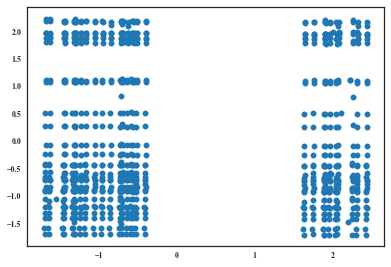

In [18]:
plt.scatter(reduced[:,0], reduced[:,1])

In [19]:
from abpytools import FabCollection, ChainCollection

In [20]:
combinations = pd.read_csv('/home/gil/PhD/Data/UCB/precollection/random_pairs.txt', index_col=0, delimiter=', ')

/home/gil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [21]:
heavy_chains = ChainCollection(path='/home/gil/PhD/Data/UCB/CombinationData/AbFiles/heavy_chains.json')
heavy_chains.load()
light_chains = ChainCollection(path='/home/gil/PhD/Data/UCB/CombinationData/AbFiles/light_chains.json')
light_chains.load()

Loading in antibody objects


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Failed to load 0 objects in list
Loading in antibody objects


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Failed to load 0 objects in list


In [22]:
heavy_chains_list=[]
light_chains_list=[]

for heavy, light in  combinations['Random Pairs'].str.split('-'):
    heavy_chains_list.append(heavy_chains.get_object(heavy))
    light_chains_list.append(light_chains.get_object(light))    

In [23]:
fab_collection = FabCollection(None, heavy_chains_list, light_chains_list,
                               names=['P' + str(x) for x in combinations.index.tolist()])

In [24]:
fab_collection.germline_identity

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

Chain   Light                                            Heavy                \
Region   CDR1   CDR2   CDR3    FR1    FR2    FR3  Total   CDR1   CDR2   CDR3   
P1      100.0   66.7  100.0  100.0   88.2   88.9   92.9   75.0   50.0  100.0   
P2       81.8  100.0   66.7   92.3  100.0  100.0   93.9   62.5   87.5   50.0   
P3       63.6   33.3  100.0   96.2   82.4   88.9   86.0  100.0  100.0  100.0   
P4       88.9   66.7   71.4   96.0   88.2   94.4   90.7   87.5   71.4  100.0   
P5      100.0   66.7  100.0  100.0   88.2   88.9   92.9   87.5   70.0   50.0   
P6       66.7  100.0   85.7   88.5  100.0   94.4   91.6   60.0   42.9  100.0   
P7       66.7   66.7   71.4  100.0   94.1  100.0   93.7   87.5   75.0  100.0   
P8       66.7   66.7   71.4  100.0   94.1  100.0   93.7   90.0   57.1  100.0   
P9       66.7   66.7  100.0   96.0   94.1   97.2   93.5   87.5   71.4  100.0   
P10      33.3  100.0   85.7   96.2   88.2   97.2   90.5   75.0   75.0   50.0   
P11      83.3  100.0   85.7  100.0   94.1   94.4   94.7   90.0  100.0    NaN   
P12      66.7  100.0   85.7   88.5  100.0   94.4   91.6   87.5  100.0  100.0   
P13      66.7   66.7   71.4  100.0   94.1  100.0   93.7   40.0   85.7  100.0   
P14      75.0  100.0   57.1   96.2  100.0  100.0   93.1  100.0   85.7  100.0   
P15      88.9   66.7   71.4   96.0   88.2   94.4   90.7   87.5   75.0  100.0   
P16      66.7  100.0  100.0  100.0  100.0   94.4   95.7  100.0  100.0  100.0   
P17      33.3  100.0   85.7   96.2   88.2   97.2   90.5   62.5   62.5  100.0   
P18      63.6   33.3  100.0   96.2   82.4   88.9   86.0   87.5   75.0  100.0   
P19      66.7  100.0  100.0  100.0  100.0   94.4   95.7   62.5  100.0  100.0   
P20      66.7   66.7   83.3  100.0  100.0   91.7   92.6   75.0  100.0  100.0   
P21     100.0  100.0   50.0  100.0  100.0  100.0   95.9   62.5   87.5  100.0   
P22      83.3  100.0   85.7  100.0   94.1   94.4   94.7   60.0   42.9  100.0   
P23     100.0   66.7  100.0  100.0   88.2   88.9   92.9   87.5  100.0  100.0   
P24      66.7   66.7  100.0   96.0   94.1   97.2   93.5   75.0  100.0  100.0   
P25      50.0  100.0   71.4   72.0   82.4   77.8   74.0   87.5   71.4  100.0   
P26      66.7   66.7   71.4  100.0   94.1  100.0   93.7   75.0   50.0  100.0   
P27      88.9   33.3   85.7  100.0   76.5   94.4   89.7   75.0   75.0  100.0   
P28      88.9   66.7   71.4   96.0   88.2   94.4   90.7  100.0   85.7  100.0   
P29      66.7  100.0  100.0  100.0  100.0   94.4   95.7   62.5   87.5  100.0   
P30      88.9   66.7  100.0   92.0  100.0   88.9   91.8   62.5   62.5  100.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
P871     66.7  100.0   85.7   88.5  100.0   94.4   91.6  100.0   87.5  100.0   
P872    100.0  100.0   88.9  100.0  100.0   94.4   96.9   75.0  100.0  100.0   
P873     66.7   66.7   83.3  100.0  100.0   91.7   92.6   62.5   62.5  100.0   
P874    100.0  100.0   50.0  100.0  100.0  100.0   95.9  100.0  100.0  100.0   
P875    100.0  100.0   88.9  100.0  100.0   94.4   96.9   87.5   50.0  100.0   
P876     33.3   66.7   60.0   96.2   94.1   94.4   88.2   40.0   85.7  100.0   
P877    100.0  100.0   50.0  100.0  100.0  100.0   95.9  100.0   87.5  100.0   
P878    100.0  100.0  100.0   92.3  100.0  100.0   97.9   62.5   87.5   50.0   
P879     88.9   66.7   71.4   96.0   88.2   94.4   90.7   75.0   75.0  100.0   
P880    100.0   66.7    0.0  100.0   94.1  100.0   94.6   60.0   42.9  100.0   
P881     33.3  100.0   71.4   84.6   82.4   86.1   81.1   60.0   42.9  100.0   
P882     33.3  100.0   71.4   84.6   82.4   86.1   81.1   62.5   62.5  100.0   
P883     33.3  100.0   85.7   96.2   88.2  100.0   91.6   70.0   71.4  100.0   
P884     88.9   66.7  100.0   92.0  100.0   88.9   91.8  100.0   71.4  100.0   
P885     75.0  100.0   57.1   96.2  100.0  100.0   93.1   90.0  100.0    NaN   
P886     33.3  100.0   71.4   84.6   82.4   86.1   81.1   87.5   87.5  100.0   
P887     81.8  100.0   66.7   92.3  100.0  100.0   93.9  100.0  100.0  100.0   


In [25]:
lambda_kappa = fab_collection.germline['Light']['Assignment'].apply(lambda x: 1 if x.startswith('IGL') else 0).values

/home/gil/anaconda3/lib/python3.6/site-packages/abpytools/core/fab_collection.py:164: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df = df.convert_objects(convert_numeric=True)


/home/gil/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The Vega10_r colormap was deprecated in version 2.0. Use tab10_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


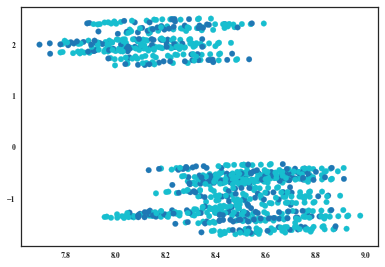

In [26]:
svd = TruncatedSVD()
reduced = svd.fit_transform(hydrophobicity_pd.as_matrix())
plt.scatter(reduced[:,0], reduced[:,1], c=lambda_kappa, cmap='Vega10_r')

In [27]:
hydrophobicity_pd.describe()

,H1,H10,H100,H100A,H100B,H100C,H100D,H100E,H100F,H100G,...,L95A,L95B,L95C,L95D,L95E,L95F,L96,L97,L98,L99
count,900.0,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,...,900.000000,900.000000,900.0,900.0,900.0,900.0,900.00000,900.000000,900.0,900.0
mean,0.0,0.063333,0.296667,0.527778,0.433333,0.300000,0.500000,0.266667,0.170000,0.170000,...,0.100000,0.066667,0.0,0.0,0.0,0.0,0.60000,0.333333,1.0,0.0
std,0.0,0.243697,0.457042,0.499505,0.495811,0.458512,0.500278,0.442463,0.375842,0.375842,...,0.300167,0.249583,0.0,0.0,0.0,0.0,0.49017,0.471667,0.0,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,1.0,0.0
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,1.0,0.0
50%,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,1.00000,0.000000,1.0,0.0
75%,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,1.00000,1.000000,1.0,0.0
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00000,1.000000,1.0,0.0


In [28]:
from natsort import natsorted

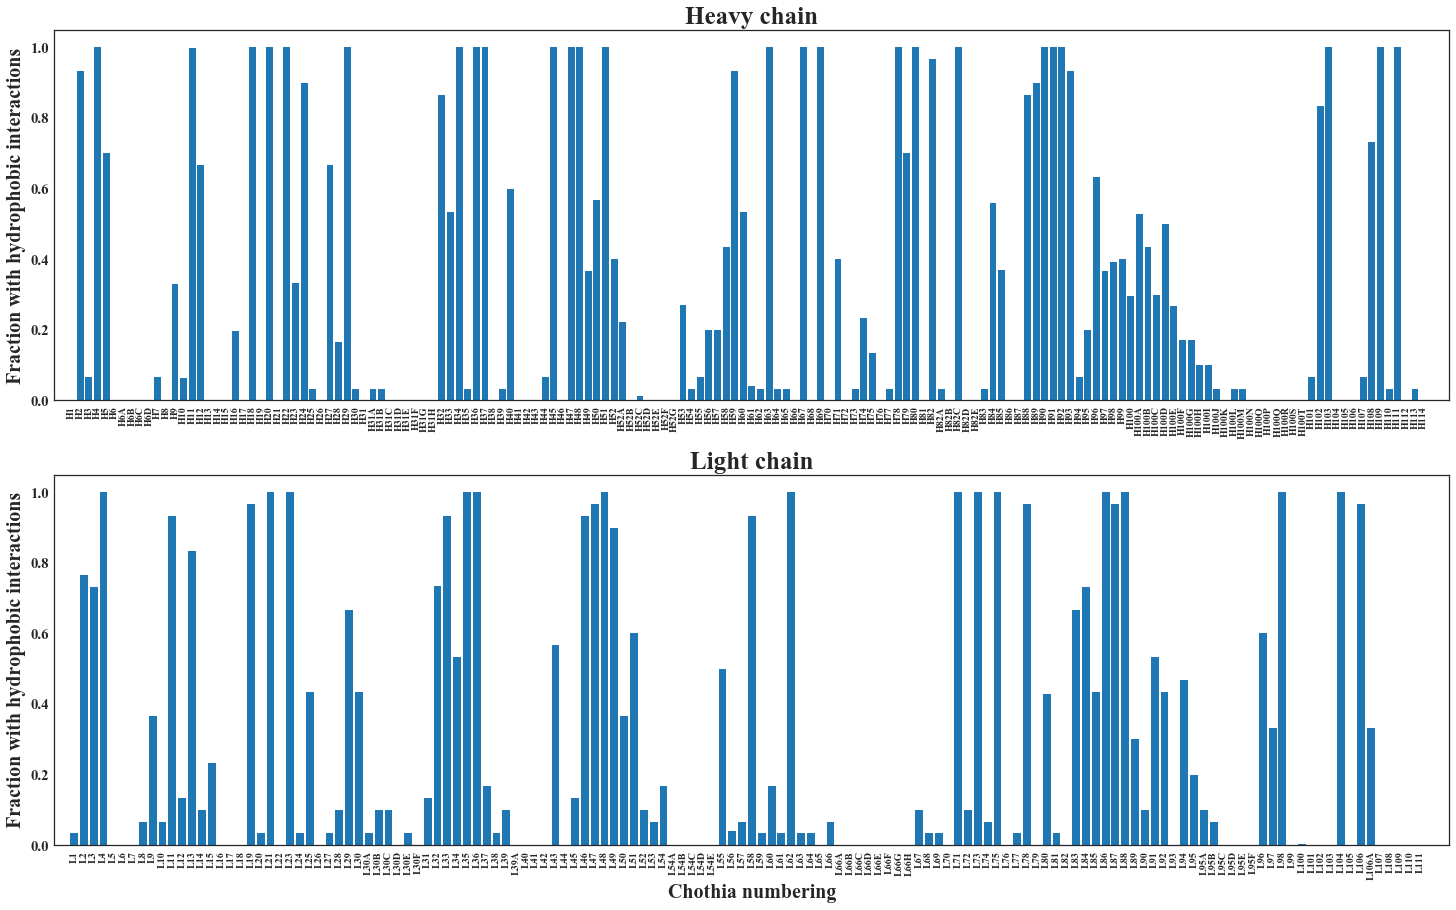

In [29]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 10,
                              'ytick.labelsize': 15, 'legend.fontsize': 15}):
    f, ax = plt.subplots(2, 1, figsize=(25, 15))
    
    data = [hydrophobicity_pd[x].mean() for x in natsorted(hydrophobicity_pd.columns) if x.startswith('H')]
    
    ax[0].bar(range(len(data)), data)
    ax[0].set_xticks(range(len(data)))
    ax[0].set_xticklabels([x for x in natsorted(hydrophobicity_pd.columns) if x.startswith('H')], rotation=90)
    ax[0].set_xlim([-2,len(data)+2])
    ax[0].set_title('Heavy chain')
    ax[0].set_ylabel('Fraction with hydrophobic interactions')
    
    data = [hydrophobicity_pd[x].mean() for x in natsorted(hydrophobicity_pd.columns) if x.startswith('L')]
    
    ax[1].bar(range(len(data)), data)
    ax[1].set_xticks(range(len(data)))
    ax[1].set_xticklabels([x for x in natsorted(hydrophobicity_pd.columns) if x.startswith('L')], rotation=90)
    ax[1].set_xlim([-2,len(data)+2])
    ax[1].set_title('Light chain')
    ax[1].set_ylabel('Fraction with hydrophobic interactions')
    ax[1].set_xlabel('Chothia numbering')

In [30]:
data = pd.read_csv('/home/gil/PhD/Data/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

In [31]:
data.head()

,Tm D - Mean,Tm D - Std. Error,Tm2 - Mean,Tm2 - Std. Error
P2,64.473820,0.000000,NaN,NaN
P3,73.982970,0.130358,NaN,NaN
P4,64.326010,0.060344,NaN,NaN
P6,74.192370,0.036953,NaN,NaN
P9,72.899025,0.085337,NaN,NaN


In [32]:
data = data.join(hydrophobicity_pd)

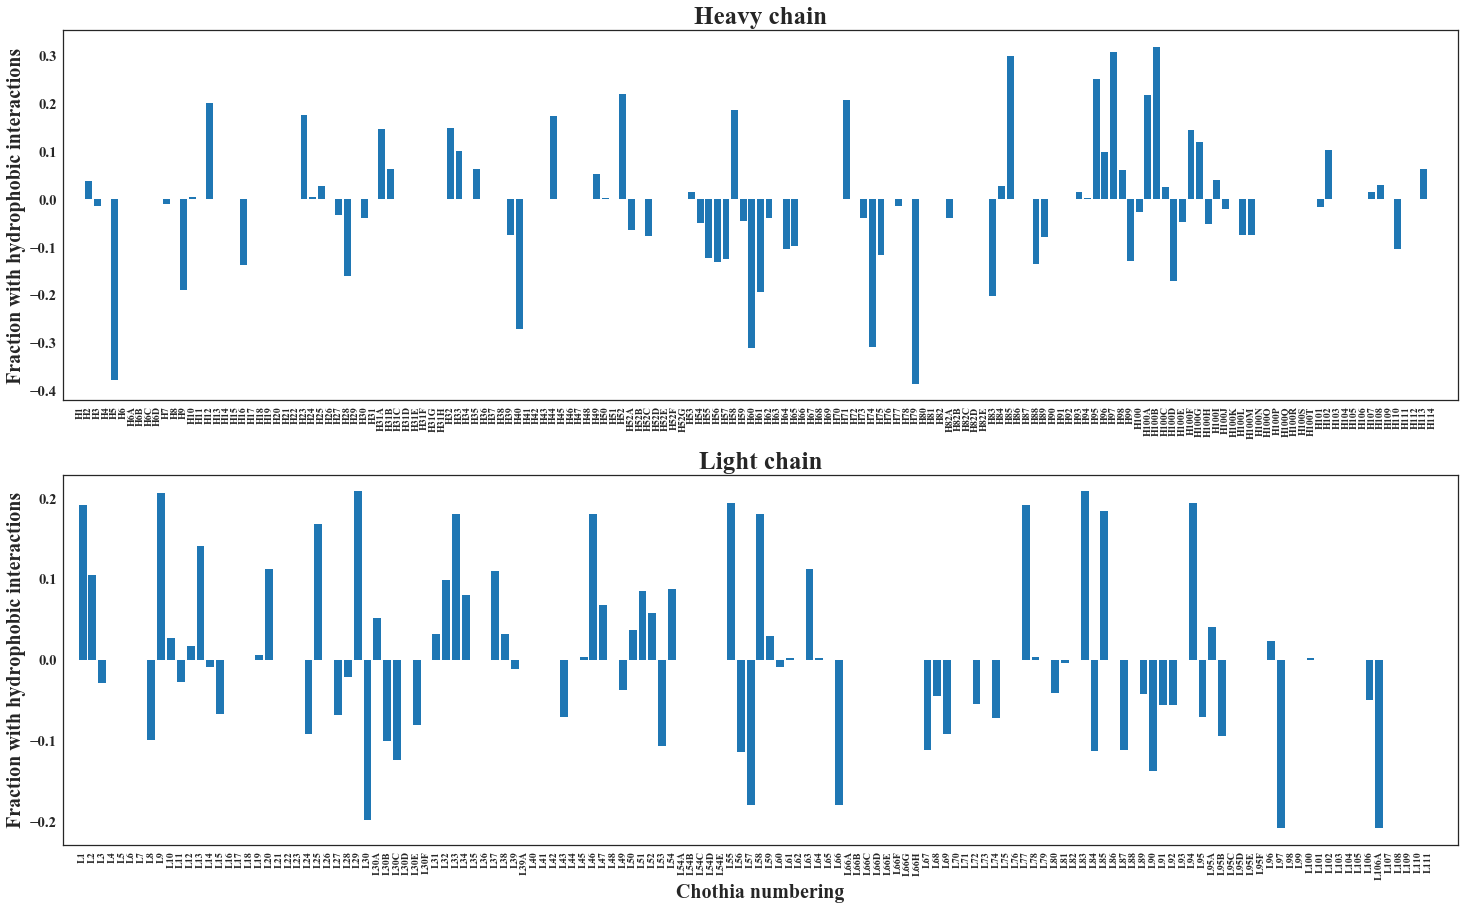

In [33]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 10,
                              'ytick.labelsize': 15, 'legend.fontsize': 15}):
    f, ax = plt.subplots(2, 1, figsize=(25, 15))

    data_ = [data[x].corr(data['Tm D - Mean']) for x in natsorted(hydrophobicity_pd.columns) if x.startswith('H')]
     
    ax[0].bar(range(len(data_)), data_)
    ax[0].set_xticks(range(len(data_)))
    ax[0].set_xticklabels([x for x in natsorted(hydrophobicity_pd.columns) if x.startswith('H')], rotation=90)
    ax[0].set_xlim([-2,len(data_)+2])
    ax[0].set_title('Heavy chain')
    ax[0].set_ylabel('Fraction with hydrophobic interactions')
    
    data_ = [data[x].corr(data['Tm D - Mean']) for x in natsorted(hydrophobicity_pd.columns) if x.startswith('L')]
    
    ax[1].bar(range(len(data_)), data_)
    ax[1].set_xticks(range(len(data_)))
    ax[1].set_xticklabels([x for x in natsorted(hydrophobicity_pd.columns) if x.startswith('L')], rotation=90)
    ax[1].set_xlim([-2,len(data_)+2])
    ax[1].set_title('Light chain')
    ax[1].set_ylabel('Fraction with hydrophobic interactions')
    ax[1].set_xlabel('Chothia numbering')

In [34]:
data = data.join(pd.DataFrame(reduced, index = fab_collection.names,columns=['PC1', 'PC2']))

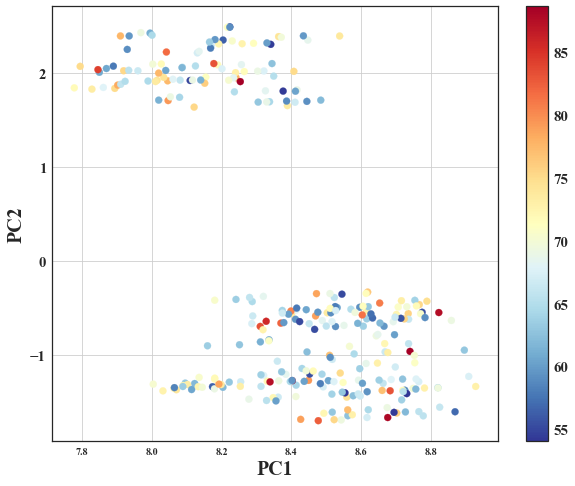

In [35]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 10,
                              'ytick.labelsize': 15, 'legend.fontsize': 15}):
    f, ax = plt.subplots(1, 1, figsize=(10, 8))

    svd = TruncatedSVD()
    reduced = svd.fit_transform(hydrophobicity_pd.as_matrix())
    plt.scatter(data['PC1'], data['PC2'], c=data['Tm D - Mean'], cmap='RdYlBu_r', s=50)
    plt.colorbar()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    plt.grid()

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

Using TensorFlow backend.


In [37]:
data = data[~np.isnan(data['Tm D - Mean'])]

In [38]:
data.ix[:,4:-2].shape[1]

/home/gil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


296

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data.ix[:,4:-2].values, data['Tm D - Mean'].values, 
                                                    test_size=0.3, random_state=1970)

In [45]:
model = Sequential()
model.add(Dense(1, input_dim=data.ix[:,4:-2].shape[1]))
# model.add(BatchNormalization())
# model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mean_squared_error',metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 297       
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________


In [46]:
from keras.callbacks import ModelCheckpoint

In [47]:
callbacks = ModelCheckpoint('./bestHydrophobicityClusterModel.h5', save_best_only=True)

history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_test, y_test), callbacks=[callbacks])

Train on 212 samples, validate on 92 samples
Epoch 1/2000
212/212 [==============================] - 0s - loss: 4535.7891 - mean_squared_error: 4535.7891 - val_loss: 4375.3758 - val_mean_squared_error: 4375.3758
Epoch 2/2000
212/212 [==============================] - 0s - loss: 4411.5793 - mean_squared_error: 4411.5793 - val_loss: 4277.2323 - val_mean_squared_error: 4277.2323
Epoch 3/2000
212/212 [==============================] - 0s - loss: 4317.7677 - mean_squared_error: 4317.7677 - val_loss: 4190.3380 - val_mean_squared_error: 4190.3380
Epoch 4/2000
212/212 [==============================] - 0s - loss: 4232.0385 - mean_squared_error: 4232.0385 - val_loss: 4108.3869 - val_mean_squared_error: 4108.3869
Epoch 5/2000
212/212 [==============================] - 0s - loss: 4150.0730 - mean_squared_error: 4150.0730 - val_loss: 4029.1629 - val_mean_squared_error: 4029.1629
Epoch 6/2000
212/212 [==============================] - 0s - loss: 4070.4378 - mean_squared_error: 4070.4378 - val_loss:

212/212 [==============================] - 0s - loss: 1416.7294 - mean_squared_error: 1416.7294 - val_loss: 1355.3868 - val_mean_squared_error: 1355.3868
Epoch 50/2000
212/212 [==============================] - 0s - loss: 1371.9979 - mean_squared_error: 1371.9979 - val_loss: 1311.8092 - val_mean_squared_error: 1311.8092
Epoch 51/2000
212/212 [==============================] - 0s - loss: 1328.0549 - mean_squared_error: 1328.0549 - val_loss: 1268.9343 - val_mean_squared_error: 1268.9343
Epoch 52/2000
212/212 [==============================] - 0s - loss: 1284.7993 - mean_squared_error: 1284.7993 - val_loss: 1226.6293 - val_mean_squared_error: 1226.6293
Epoch 53/2000
212/212 [==============================] - 0s - loss: 1242.1381 - mean_squared_error: 1242.1381 - val_loss: 1185.1029 - val_mean_squared_error: 1185.1029
Epoch 54/2000
212/212 [==============================] - 0s - loss: 1200.4734 - mean_squared_error: 1200.4734 - val_loss: 1144.8462 - val_mean_squared_error: 1144.8462
Epoch 

212/212 [==============================] - 0s - loss: 113.5296 - mean_squared_error: 113.5296 - val_loss: 96.2285 - val_mean_squared_error: 96.2285
Epoch 99/2000
212/212 [==============================] - 0s - loss: 105.3721 - mean_squared_error: 105.3721 - val_loss: 88.9040 - val_mean_squared_error: 88.9040
Epoch 100/2000
212/212 [==============================] - 0s - loss: 98.0137 - mean_squared_error: 98.0137 - val_loss: 81.9016 - val_mean_squared_error: 81.9016
Epoch 101/2000
212/212 [==============================] - 0s - loss: 91.1279 - mean_squared_error: 91.1279 - val_loss: 75.7323 - val_mean_squared_error: 75.7323
Epoch 102/2000
212/212 [==============================] - 0s - loss: 85.1087 - mean_squared_error: 85.1087 - val_loss: 70.3600 - val_mean_squared_error: 70.3600
Epoch 103/2000
212/212 [==============================] - 0s - loss: 79.6632 - mean_squared_error: 79.6632 - val_loss: 65.2797 - val_mean_squared_error: 65.2797
Epoch 104/2000
212/212 [======================

212/212 [==============================] - 0s - loss: 44.1725 - mean_squared_error: 44.1725 - val_loss: 36.9034 - val_mean_squared_error: 36.9034
Epoch 149/2000
212/212 [==============================] - 0s - loss: 43.9337 - mean_squared_error: 43.9337 - val_loss: 36.7421 - val_mean_squared_error: 36.7421
Epoch 150/2000
212/212 [==============================] - 0s - loss: 43.7419 - mean_squared_error: 43.7419 - val_loss: 36.6046 - val_mean_squared_error: 36.6046
Epoch 151/2000
212/212 [==============================] - 0s - loss: 43.5007 - mean_squared_error: 43.5007 - val_loss: 36.4598 - val_mean_squared_error: 36.4598
Epoch 152/2000
212/212 [==============================] - 0s - loss: 43.2695 - mean_squared_error: 43.2695 - val_loss: 36.3274 - val_mean_squared_error: 36.3274
Epoch 153/2000
212/212 [==============================] - 0s - loss: 43.0564 - mean_squared_error: 43.0564 - val_loss: 36.1733 - val_mean_squared_error: 36.1733
Epoch 154/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 36.0062 - mean_squared_error: 36.0062 - val_loss: 31.2273 - val_mean_squared_error: 31.2273
Epoch 199/2000
212/212 [==============================] - 0s - loss: 35.8866 - mean_squared_error: 35.8866 - val_loss: 31.1814 - val_mean_squared_error: 31.1814
Epoch 200/2000
212/212 [==============================] - 0s - loss: 35.8262 - mean_squared_error: 35.8262 - val_loss: 31.0831 - val_mean_squared_error: 31.0831
Epoch 201/2000
212/212 [==============================] - 0s - loss: 35.6321 - mean_squared_error: 35.6321 - val_loss: 30.9612 - val_mean_squared_error: 30.9612
Epoch 202/2000
212/212 [==============================] - 0s - loss: 35.5792 - mean_squared_error: 35.5792 - val_loss: 30.8434 - val_mean_squared_error: 30.8434
Epoch 203/2000
212/212 [==============================] - 0s - loss: 35.4337 - mean_squared_error: 35.4337 - val_loss: 30.8048 - val_mean_squared_error: 30.8048
Epoch 204/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 31.4737 - mean_squared_error: 31.4737 - val_loss: 28.1159 - val_mean_squared_error: 28.1159
Epoch 249/2000
212/212 [==============================] - 0s - loss: 31.3916 - mean_squared_error: 31.3916 - val_loss: 27.9954 - val_mean_squared_error: 27.9954
Epoch 250/2000
212/212 [==============================] - 0s - loss: 31.2958 - mean_squared_error: 31.2958 - val_loss: 27.9726 - val_mean_squared_error: 27.9726
Epoch 251/2000
212/212 [==============================] - 0s - loss: 31.2706 - mean_squared_error: 31.2706 - val_loss: 27.9418 - val_mean_squared_error: 27.9418
Epoch 252/2000
212/212 [==============================] - 0s - loss: 31.1554 - mean_squared_error: 31.1554 - val_loss: 27.8388 - val_mean_squared_error: 27.8388
Epoch 253/2000
212/212 [==============================] - 0s - loss: 31.1388 - mean_squared_error: 31.1388 - val_loss: 27.7444 - val_mean_squared_error: 27.7444
Epoch 254/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 28.4871 - mean_squared_error: 28.4871 - val_loss: 25.8145 - val_mean_squared_error: 25.8145
Epoch 299/2000
212/212 [==============================] - 0s - loss: 28.4409 - mean_squared_error: 28.4409 - val_loss: 25.8571 - val_mean_squared_error: 25.8571
Epoch 300/2000
212/212 [==============================] - 0s - loss: 28.3781 - mean_squared_error: 28.3781 - val_loss: 25.8212 - val_mean_squared_error: 25.8212
Epoch 301/2000
212/212 [==============================] - 0s - loss: 28.3076 - mean_squared_error: 28.3076 - val_loss: 25.6907 - val_mean_squared_error: 25.6907
Epoch 302/2000
212/212 [==============================] - 0s - loss: 28.2675 - mean_squared_error: 28.2675 - val_loss: 25.6135 - val_mean_squared_error: 25.6135
Epoch 303/2000
212/212 [==============================] - 0s - loss: 28.2811 - mean_squared_error: 28.2811 - val_loss: 25.6174 - val_mean_squared_error: 25.6174
Epoch 304/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 26.3220 - mean_squared_error: 26.3220 - val_loss: 24.0814 - val_mean_squared_error: 24.0814
Epoch 349/2000
212/212 [==============================] - 0s - loss: 26.2736 - mean_squared_error: 26.2736 - val_loss: 24.0300 - val_mean_squared_error: 24.0300
Epoch 350/2000
212/212 [==============================] - 0s - loss: 26.2527 - mean_squared_error: 26.2527 - val_loss: 24.0471 - val_mean_squared_error: 24.0471
Epoch 351/2000
212/212 [==============================] - 0s - loss: 26.2658 - mean_squared_error: 26.2658 - val_loss: 24.0373 - val_mean_squared_error: 24.0373
Epoch 352/2000
212/212 [==============================] - 0s - loss: 26.1604 - mean_squared_error: 26.1604 - val_loss: 24.0228 - val_mean_squared_error: 24.0228
Epoch 353/2000
212/212 [==============================] - 0s - loss: 26.1137 - mean_squared_error: 26.1137 - val_loss: 23.8986 - val_mean_squared_error: 23.8986
Epoch 354/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 24.7061 - mean_squared_error: 24.7061 - val_loss: 22.4974 - val_mean_squared_error: 22.4974
Epoch 399/2000
212/212 [==============================] - 0s - loss: 24.6431 - mean_squared_error: 24.6431 - val_loss: 22.5187 - val_mean_squared_error: 22.5187
Epoch 400/2000
212/212 [==============================] - 0s - loss: 24.5862 - mean_squared_error: 24.5862 - val_loss: 22.4405 - val_mean_squared_error: 22.4405
Epoch 401/2000
212/212 [==============================] - 0s - loss: 24.6352 - mean_squared_error: 24.6352 - val_loss: 22.5212 - val_mean_squared_error: 22.5212
Epoch 402/2000
212/212 [==============================] - 0s - loss: 24.5217 - mean_squared_error: 24.5217 - val_loss: 22.5876 - val_mean_squared_error: 22.5876
Epoch 403/2000
212/212 [==============================] - 0s - loss: 24.5324 - mean_squared_error: 24.5324 - val_loss: 22.5886 - val_mean_squared_error: 22.5886
Epoch 404/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 23.3995 - mean_squared_error: 23.3995 - val_loss: 21.3916 - val_mean_squared_error: 21.3916
Epoch 449/2000
212/212 [==============================] - 0s - loss: 23.3410 - mean_squared_error: 23.3410 - val_loss: 21.4708 - val_mean_squared_error: 21.4708
Epoch 450/2000
212/212 [==============================] - 0s - loss: 23.3112 - mean_squared_error: 23.3112 - val_loss: 21.5256 - val_mean_squared_error: 21.5256
Epoch 451/2000
212/212 [==============================] - 0s - loss: 23.3171 - mean_squared_error: 23.3171 - val_loss: 21.4191 - val_mean_squared_error: 21.4191
Epoch 452/2000
212/212 [==============================] - 0s - loss: 23.2488 - mean_squared_error: 23.2488 - val_loss: 21.4010 - val_mean_squared_error: 21.4010
Epoch 453/2000
212/212 [==============================] - 0s - loss: 23.2732 - mean_squared_error: 23.2732 - val_loss: 21.3889 - val_mean_squared_error: 21.3889
Epoch 454/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 22.3774 - mean_squared_error: 22.3774 - val_loss: 20.6180 - val_mean_squared_error: 20.6180
Epoch 499/2000
212/212 [==============================] - 0s - loss: 22.3297 - mean_squared_error: 22.3297 - val_loss: 20.5951 - val_mean_squared_error: 20.5951
Epoch 500/2000
212/212 [==============================] - 0s - loss: 22.2799 - mean_squared_error: 22.2799 - val_loss: 20.5803 - val_mean_squared_error: 20.5803
Epoch 501/2000
212/212 [==============================] - 0s - loss: 22.3025 - mean_squared_error: 22.3025 - val_loss: 20.4648 - val_mean_squared_error: 20.4648
Epoch 502/2000
212/212 [==============================] - 0s - loss: 22.2949 - mean_squared_error: 22.2949 - val_loss: 20.4408 - val_mean_squared_error: 20.4408
Epoch 503/2000
212/212 [==============================] - 0s - loss: 22.2471 - mean_squared_error: 22.2471 - val_loss: 20.5080 - val_mean_squared_error: 20.5080
Epoch 504/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 21.5282 - mean_squared_error: 21.5282 - val_loss: 19.8032 - val_mean_squared_error: 19.8032
Epoch 549/2000
212/212 [==============================] - 0s - loss: 21.5224 - mean_squared_error: 21.5224 - val_loss: 19.7129 - val_mean_squared_error: 19.7129
Epoch 550/2000
212/212 [==============================] - 0s - loss: 21.4967 - mean_squared_error: 21.4967 - val_loss: 19.8030 - val_mean_squared_error: 19.8030
Epoch 551/2000
212/212 [==============================] - 0s - loss: 21.4584 - mean_squared_error: 21.4584 - val_loss: 19.7081 - val_mean_squared_error: 19.7081
Epoch 552/2000
212/212 [==============================] - 0s - loss: 21.4753 - mean_squared_error: 21.4753 - val_loss: 19.8250 - val_mean_squared_error: 19.8250
Epoch 553/2000
212/212 [==============================] - 0s - loss: 21.4412 - mean_squared_error: 21.4412 - val_loss: 19.8303 - val_mean_squared_error: 19.8303
Epoch 554/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 20.8354 - mean_squared_error: 20.8354 - val_loss: 19.2495 - val_mean_squared_error: 19.2495
Epoch 599/2000
212/212 [==============================] - 0s - loss: 20.8454 - mean_squared_error: 20.8454 - val_loss: 19.2652 - val_mean_squared_error: 19.2652
Epoch 600/2000
212/212 [==============================] - 0s - loss: 20.7891 - mean_squared_error: 20.7891 - val_loss: 19.2122 - val_mean_squared_error: 19.2122
Epoch 601/2000
212/212 [==============================] - 0s - loss: 20.7810 - mean_squared_error: 20.7810 - val_loss: 19.0999 - val_mean_squared_error: 19.0999
Epoch 602/2000
212/212 [==============================] - 0s - loss: 20.7893 - mean_squared_error: 20.7893 - val_loss: 19.0658 - val_mean_squared_error: 19.0658
Epoch 603/2000
212/212 [==============================] - 0s - loss: 20.7796 - mean_squared_error: 20.7796 - val_loss: 19.1041 - val_mean_squared_error: 19.1041
Epoch 604/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 20.3372 - mean_squared_error: 20.3372 - val_loss: 18.7411 - val_mean_squared_error: 18.7411
Epoch 649/2000
212/212 [==============================] - 0s - loss: 20.2956 - mean_squared_error: 20.2956 - val_loss: 18.8189 - val_mean_squared_error: 18.8189
Epoch 650/2000
212/212 [==============================] - 0s - loss: 20.2628 - mean_squared_error: 20.2628 - val_loss: 18.7620 - val_mean_squared_error: 18.7620
Epoch 651/2000
212/212 [==============================] - 0s - loss: 20.2803 - mean_squared_error: 20.2803 - val_loss: 18.6876 - val_mean_squared_error: 18.6876
Epoch 652/2000
212/212 [==============================] - 0s - loss: 20.2370 - mean_squared_error: 20.2370 - val_loss: 18.6372 - val_mean_squared_error: 18.6372
Epoch 653/2000
212/212 [==============================] - 0s - loss: 20.2427 - mean_squared_error: 20.2427 - val_loss: 18.5981 - val_mean_squared_error: 18.5981
Epoch 654/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 19.8217 - mean_squared_error: 19.8217 - val_loss: 18.3187 - val_mean_squared_error: 18.3187
Epoch 699/2000
212/212 [==============================] - 0s - loss: 19.7740 - mean_squared_error: 19.7740 - val_loss: 18.3742 - val_mean_squared_error: 18.3742
Epoch 700/2000
212/212 [==============================] - 0s - loss: 19.7747 - mean_squared_error: 19.7747 - val_loss: 18.3881 - val_mean_squared_error: 18.3881
Epoch 701/2000
212/212 [==============================] - 0s - loss: 19.7620 - mean_squared_error: 19.7620 - val_loss: 18.3550 - val_mean_squared_error: 18.3550
Epoch 702/2000
212/212 [==============================] - 0s - loss: 19.7755 - mean_squared_error: 19.7755 - val_loss: 18.2535 - val_mean_squared_error: 18.2535
Epoch 703/2000
212/212 [==============================] - 0s - loss: 19.7670 - mean_squared_error: 19.7670 - val_loss: 18.1971 - val_mean_squared_error: 18.1971
Epoch 704/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 19.4085 - mean_squared_error: 19.4085 - val_loss: 18.0218 - val_mean_squared_error: 18.0218
Epoch 749/2000
212/212 [==============================] - 0s - loss: 19.4078 - mean_squared_error: 19.4078 - val_loss: 17.9965 - val_mean_squared_error: 17.9965
Epoch 750/2000
212/212 [==============================] - 0s - loss: 19.4051 - mean_squared_error: 19.4051 - val_loss: 18.0792 - val_mean_squared_error: 18.0792
Epoch 751/2000
212/212 [==============================] - 0s - loss: 19.3659 - mean_squared_error: 19.3659 - val_loss: 18.2038 - val_mean_squared_error: 18.2038
Epoch 752/2000
212/212 [==============================] - 0s - loss: 19.4049 - mean_squared_error: 19.4049 - val_loss: 18.0596 - val_mean_squared_error: 18.0596
Epoch 753/2000
212/212 [==============================] - 0s - loss: 19.3791 - mean_squared_error: 19.3791 - val_loss: 18.0045 - val_mean_squared_error: 18.0045
Epoch 754/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 19.0586 - mean_squared_error: 19.0586 - val_loss: 17.8793 - val_mean_squared_error: 17.8793
Epoch 799/2000
212/212 [==============================] - 0s - loss: 19.0900 - mean_squared_error: 19.0900 - val_loss: 17.8400 - val_mean_squared_error: 17.8400
Epoch 800/2000
212/212 [==============================] - 0s - loss: 19.0399 - mean_squared_error: 19.0399 - val_loss: 17.8975 - val_mean_squared_error: 17.8975
Epoch 801/2000
212/212 [==============================] - 0s - loss: 19.0607 - mean_squared_error: 19.0607 - val_loss: 17.8278 - val_mean_squared_error: 17.8278
Epoch 802/2000
212/212 [==============================] - 0s - loss: 19.0953 - mean_squared_error: 19.0953 - val_loss: 17.8510 - val_mean_squared_error: 17.8510
Epoch 803/2000
212/212 [==============================] - 0s - loss: 19.0474 - mean_squared_error: 19.0474 - val_loss: 17.9151 - val_mean_squared_error: 17.9151
Epoch 804/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 18.7541 - mean_squared_error: 18.7541 - val_loss: 17.8271 - val_mean_squared_error: 17.8271
Epoch 849/2000
212/212 [==============================] - 0s - loss: 18.7673 - mean_squared_error: 18.7673 - val_loss: 17.7259 - val_mean_squared_error: 17.7259
Epoch 850/2000
212/212 [==============================] - 0s - loss: 18.8254 - mean_squared_error: 18.8254 - val_loss: 17.7029 - val_mean_squared_error: 17.7029
Epoch 851/2000
212/212 [==============================] - 0s - loss: 18.7556 - mean_squared_error: 18.7556 - val_loss: 17.7832 - val_mean_squared_error: 17.7832
Epoch 852/2000
212/212 [==============================] - 0s - loss: 18.7898 - mean_squared_error: 18.7898 - val_loss: 17.7751 - val_mean_squared_error: 17.7751
Epoch 853/2000
212/212 [==============================] - 0s - loss: 18.7741 - mean_squared_error: 18.7741 - val_loss: 17.7393 - val_mean_squared_error: 17.7393
Epoch 854/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 18.4959 - mean_squared_error: 18.4959 - val_loss: 17.6440 - val_mean_squared_error: 17.6440
Epoch 899/2000
212/212 [==============================] - 0s - loss: 18.5070 - mean_squared_error: 18.5070 - val_loss: 17.5753 - val_mean_squared_error: 17.5753
Epoch 900/2000
212/212 [==============================] - 0s - loss: 18.4984 - mean_squared_error: 18.4984 - val_loss: 17.5443 - val_mean_squared_error: 17.5443
Epoch 901/2000
212/212 [==============================] - 0s - loss: 18.5176 - mean_squared_error: 18.5176 - val_loss: 17.5897 - val_mean_squared_error: 17.5897
Epoch 902/2000
212/212 [==============================] - 0s - loss: 18.5339 - mean_squared_error: 18.5339 - val_loss: 17.5969 - val_mean_squared_error: 17.5969
Epoch 903/2000
212/212 [==============================] - 0s - loss: 18.5047 - mean_squared_error: 18.5047 - val_loss: 17.5870 - val_mean_squared_error: 17.5870
Epoch 904/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 18.3219 - mean_squared_error: 18.3219 - val_loss: 17.7170 - val_mean_squared_error: 17.7170
Epoch 949/2000
212/212 [==============================] - 0s - loss: 18.2654 - mean_squared_error: 18.2654 - val_loss: 17.6186 - val_mean_squared_error: 17.6186
Epoch 950/2000
212/212 [==============================] - 0s - loss: 18.3121 - mean_squared_error: 18.3121 - val_loss: 17.6563 - val_mean_squared_error: 17.6563
Epoch 951/2000
212/212 [==============================] - 0s - loss: 18.3145 - mean_squared_error: 18.3145 - val_loss: 17.6084 - val_mean_squared_error: 17.6084
Epoch 952/2000
212/212 [==============================] - 0s - loss: 18.2762 - mean_squared_error: 18.2762 - val_loss: 17.4848 - val_mean_squared_error: 17.4848
Epoch 953/2000
212/212 [==============================] - 0s - loss: 18.3197 - mean_squared_error: 18.3197 - val_loss: 17.5484 - val_mean_squared_error: 17.5484
Epoch 954/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 18.0987 - mean_squared_error: 18.0987 - val_loss: 17.6875 - val_mean_squared_error: 17.6875
Epoch 999/2000
212/212 [==============================] - 0s - loss: 18.1077 - mean_squared_error: 18.1077 - val_loss: 17.5451 - val_mean_squared_error: 17.5451
Epoch 1000/2000
212/212 [==============================] - 0s - loss: 18.1227 - mean_squared_error: 18.1227 - val_loss: 17.5562 - val_mean_squared_error: 17.5562
Epoch 1001/2000
212/212 [==============================] - 0s - loss: 18.0554 - mean_squared_error: 18.0554 - val_loss: 17.5788 - val_mean_squared_error: 17.5788
Epoch 1002/2000
212/212 [==============================] - 0s - loss: 18.1064 - mean_squared_error: 18.1064 - val_loss: 17.6141 - val_mean_squared_error: 17.6141
Epoch 1003/2000
212/212 [==============================] - 0s - loss: 18.0432 - mean_squared_error: 18.0432 - val_loss: 17.6699 - val_mean_squared_error: 17.6699
Epoch 1004/2000
212/212 [====================

212/212 [==============================] - 0s - loss: 17.9403 - mean_squared_error: 17.9403 - val_loss: 17.6021 - val_mean_squared_error: 17.6021
Epoch 1049/2000
212/212 [==============================] - 0s - loss: 17.9033 - mean_squared_error: 17.9033 - val_loss: 17.5966 - val_mean_squared_error: 17.5966
Epoch 1050/2000
212/212 [==============================] - 0s - loss: 17.9020 - mean_squared_error: 17.9020 - val_loss: 17.5837 - val_mean_squared_error: 17.5837
Epoch 1051/2000
212/212 [==============================] - 0s - loss: 18.0106 - mean_squared_error: 18.0106 - val_loss: 17.5842 - val_mean_squared_error: 17.5842
Epoch 1052/2000
212/212 [==============================] - 0s - loss: 17.8790 - mean_squared_error: 17.8790 - val_loss: 17.6273 - val_mean_squared_error: 17.6273
Epoch 1053/2000
212/212 [==============================] - 0s - loss: 17.9019 - mean_squared_error: 17.9019 - val_loss: 17.6009 - val_mean_squared_error: 17.6009
Epoch 1054/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 17.8178 - mean_squared_error: 17.8178 - val_loss: 17.5282 - val_mean_squared_error: 17.5282
Epoch 1099/2000
212/212 [==============================] - 0s - loss: 17.7179 - mean_squared_error: 17.7179 - val_loss: 17.5330 - val_mean_squared_error: 17.5330
Epoch 1100/2000
212/212 [==============================] - 0s - loss: 17.7288 - mean_squared_error: 17.7288 - val_loss: 17.6297 - val_mean_squared_error: 17.6297
Epoch 1101/2000
212/212 [==============================] - 0s - loss: 17.7425 - mean_squared_error: 17.7425 - val_loss: 17.6894 - val_mean_squared_error: 17.6894
Epoch 1102/2000
212/212 [==============================] - 0s - loss: 17.7430 - mean_squared_error: 17.7430 - val_loss: 17.6652 - val_mean_squared_error: 17.6652
Epoch 1103/2000
212/212 [==============================] - 0s - loss: 17.7365 - mean_squared_error: 17.7365 - val_loss: 17.5559 - val_mean_squared_error: 17.5559
Epoch 1104/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 17.5886 - mean_squared_error: 17.5886 - val_loss: 17.6225 - val_mean_squared_error: 17.6225
Epoch 1149/2000
212/212 [==============================] - 0s - loss: 17.6118 - mean_squared_error: 17.6118 - val_loss: 17.6428 - val_mean_squared_error: 17.6428
Epoch 1150/2000
212/212 [==============================] - 0s - loss: 17.6077 - mean_squared_error: 17.6077 - val_loss: 17.6782 - val_mean_squared_error: 17.6782
Epoch 1151/2000
212/212 [==============================] - 0s - loss: 17.6046 - mean_squared_error: 17.6046 - val_loss: 17.5762 - val_mean_squared_error: 17.5762
Epoch 1152/2000
212/212 [==============================] - 0s - loss: 17.5770 - mean_squared_error: 17.5770 - val_loss: 17.5881 - val_mean_squared_error: 17.5881
Epoch 1153/2000
212/212 [==============================] - 0s - loss: 17.6414 - mean_squared_error: 17.6414 - val_loss: 17.6060 - val_mean_squared_error: 17.6060
Epoch 1154/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 17.4984 - mean_squared_error: 17.4984 - val_loss: 17.7520 - val_mean_squared_error: 17.7520
Epoch 1199/2000
212/212 [==============================] - 0s - loss: 17.4769 - mean_squared_error: 17.4769 - val_loss: 17.7120 - val_mean_squared_error: 17.7120
Epoch 1200/2000
212/212 [==============================] - 0s - loss: 17.4609 - mean_squared_error: 17.4609 - val_loss: 17.6615 - val_mean_squared_error: 17.6615
Epoch 1201/2000
212/212 [==============================] - 0s - loss: 17.5003 - mean_squared_error: 17.5003 - val_loss: 17.7190 - val_mean_squared_error: 17.7190
Epoch 1202/2000
212/212 [==============================] - 0s - loss: 17.4411 - mean_squared_error: 17.4411 - val_loss: 17.7803 - val_mean_squared_error: 17.7803
Epoch 1203/2000
212/212 [==============================] - 0s - loss: 17.5071 - mean_squared_error: 17.5071 - val_loss: 17.7855 - val_mean_squared_error: 17.7855
Epoch 1204/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 17.3422 - mean_squared_error: 17.3422 - val_loss: 17.6660 - val_mean_squared_error: 17.6660
Epoch 1249/2000
212/212 [==============================] - 0s - loss: 17.3115 - mean_squared_error: 17.3115 - val_loss: 17.6452 - val_mean_squared_error: 17.6452
Epoch 1250/2000
212/212 [==============================] - 0s - loss: 17.3893 - mean_squared_error: 17.3893 - val_loss: 17.7446 - val_mean_squared_error: 17.7446
Epoch 1251/2000
212/212 [==============================] - 0s - loss: 17.3357 - mean_squared_error: 17.3357 - val_loss: 17.7149 - val_mean_squared_error: 17.7149
Epoch 1252/2000
212/212 [==============================] - 0s - loss: 17.3593 - mean_squared_error: 17.3593 - val_loss: 17.7457 - val_mean_squared_error: 17.7457
Epoch 1253/2000
212/212 [==============================] - 0s - loss: 17.3646 - mean_squared_error: 17.3646 - val_loss: 17.8376 - val_mean_squared_error: 17.8376
Epoch 1254/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 17.3360 - mean_squared_error: 17.3360 - val_loss: 17.8506 - val_mean_squared_error: 17.8506
Epoch 1299/2000
212/212 [==============================] - 0s - loss: 17.2179 - mean_squared_error: 17.2179 - val_loss: 17.7467 - val_mean_squared_error: 17.7467
Epoch 1300/2000
212/212 [==============================] - 0s - loss: 17.2273 - mean_squared_error: 17.2273 - val_loss: 17.7402 - val_mean_squared_error: 17.7402
Epoch 1301/2000
212/212 [==============================] - 0s - loss: 17.2438 - mean_squared_error: 17.2438 - val_loss: 17.7245 - val_mean_squared_error: 17.7245
Epoch 1302/2000
212/212 [==============================] - 0s - loss: 17.3133 - mean_squared_error: 17.3133 - val_loss: 17.7266 - val_mean_squared_error: 17.7266
Epoch 1303/2000
212/212 [==============================] - 0s - loss: 17.2048 - mean_squared_error: 17.2048 - val_loss: 17.7388 - val_mean_squared_error: 17.7388
Epoch 1304/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 17.1561 - mean_squared_error: 17.1561 - val_loss: 17.8188 - val_mean_squared_error: 17.8188
Epoch 1349/2000
212/212 [==============================] - 0s - loss: 17.1394 - mean_squared_error: 17.1394 - val_loss: 17.8734 - val_mean_squared_error: 17.8734
Epoch 1350/2000
212/212 [==============================] - 0s - loss: 17.1330 - mean_squared_error: 17.1330 - val_loss: 17.7615 - val_mean_squared_error: 17.7615
Epoch 1351/2000
212/212 [==============================] - 0s - loss: 17.1535 - mean_squared_error: 17.1535 - val_loss: 17.7282 - val_mean_squared_error: 17.7282
Epoch 1352/2000
212/212 [==============================] - 0s - loss: 17.2184 - mean_squared_error: 17.2184 - val_loss: 17.7750 - val_mean_squared_error: 17.7750
Epoch 1353/2000
212/212 [==============================] - 0s - loss: 17.1602 - mean_squared_error: 17.1602 - val_loss: 17.8356 - val_mean_squared_error: 17.8356
Epoch 1354/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 17.0400 - mean_squared_error: 17.0400 - val_loss: 17.9447 - val_mean_squared_error: 17.9447
Epoch 1399/2000
212/212 [==============================] - 0s - loss: 17.0486 - mean_squared_error: 17.0486 - val_loss: 17.8216 - val_mean_squared_error: 17.8216
Epoch 1400/2000
212/212 [==============================] - 0s - loss: 17.1272 - mean_squared_error: 17.1272 - val_loss: 17.8422 - val_mean_squared_error: 17.8422
Epoch 1401/2000
212/212 [==============================] - 0s - loss: 17.1003 - mean_squared_error: 17.1003 - val_loss: 17.8620 - val_mean_squared_error: 17.8620
Epoch 1402/2000
212/212 [==============================] - 0s - loss: 17.0350 - mean_squared_error: 17.0350 - val_loss: 17.8720 - val_mean_squared_error: 17.8720
Epoch 1403/2000
212/212 [==============================] - 0s - loss: 17.0355 - mean_squared_error: 17.0355 - val_loss: 17.8772 - val_mean_squared_error: 17.8772
Epoch 1404/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.9612 - mean_squared_error: 16.9612 - val_loss: 18.1410 - val_mean_squared_error: 18.1410
Epoch 1449/2000
212/212 [==============================] - 0s - loss: 16.9647 - mean_squared_error: 16.9647 - val_loss: 18.0865 - val_mean_squared_error: 18.0865
Epoch 1450/2000
212/212 [==============================] - 0s - loss: 16.9554 - mean_squared_error: 16.9554 - val_loss: 17.9787 - val_mean_squared_error: 17.9787
Epoch 1451/2000
212/212 [==============================] - 0s - loss: 16.9392 - mean_squared_error: 16.9392 - val_loss: 17.9778 - val_mean_squared_error: 17.9778
Epoch 1452/2000
212/212 [==============================] - 0s - loss: 16.9577 - mean_squared_error: 16.9577 - val_loss: 18.0186 - val_mean_squared_error: 18.0186
Epoch 1453/2000
212/212 [==============================] - 0s - loss: 16.9959 - mean_squared_error: 16.9959 - val_loss: 17.9528 - val_mean_squared_error: 17.9528
Epoch 1454/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.8847 - mean_squared_error: 16.8847 - val_loss: 17.9736 - val_mean_squared_error: 17.9736
Epoch 1499/2000
212/212 [==============================] - 0s - loss: 16.8700 - mean_squared_error: 16.8700 - val_loss: 17.9933 - val_mean_squared_error: 17.9933
Epoch 1500/2000
212/212 [==============================] - 0s - loss: 16.9205 - mean_squared_error: 16.9205 - val_loss: 17.9668 - val_mean_squared_error: 17.9668
Epoch 1501/2000
212/212 [==============================] - 0s - loss: 16.8955 - mean_squared_error: 16.8955 - val_loss: 18.0446 - val_mean_squared_error: 18.0446
Epoch 1502/2000
212/212 [==============================] - 0s - loss: 16.9156 - mean_squared_error: 16.9156 - val_loss: 18.1225 - val_mean_squared_error: 18.1225
Epoch 1503/2000
212/212 [==============================] - 0s - loss: 16.9177 - mean_squared_error: 16.9177 - val_loss: 18.1043 - val_mean_squared_error: 18.1043
Epoch 1504/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.7954 - mean_squared_error: 16.7954 - val_loss: 18.1782 - val_mean_squared_error: 18.1782
Epoch 1549/2000
212/212 [==============================] - 0s - loss: 16.8236 - mean_squared_error: 16.8236 - val_loss: 18.1746 - val_mean_squared_error: 18.1746
Epoch 1550/2000
212/212 [==============================] - 0s - loss: 16.8586 - mean_squared_error: 16.8586 - val_loss: 18.1783 - val_mean_squared_error: 18.1783
Epoch 1551/2000
212/212 [==============================] - 0s - loss: 16.8418 - mean_squared_error: 16.8418 - val_loss: 18.0254 - val_mean_squared_error: 18.0254
Epoch 1552/2000
212/212 [==============================] - 0s - loss: 16.8060 - mean_squared_error: 16.8060 - val_loss: 18.0967 - val_mean_squared_error: 18.0967
Epoch 1553/2000
212/212 [==============================] - 0s - loss: 16.8203 - mean_squared_error: 16.8203 - val_loss: 18.0784 - val_mean_squared_error: 18.0784
Epoch 1554/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.7866 - mean_squared_error: 16.7866 - val_loss: 18.1808 - val_mean_squared_error: 18.1808
Epoch 1599/2000
212/212 [==============================] - 0s - loss: 16.7483 - mean_squared_error: 16.7483 - val_loss: 18.2255 - val_mean_squared_error: 18.2255
Epoch 1600/2000
212/212 [==============================] - 0s - loss: 16.7264 - mean_squared_error: 16.7264 - val_loss: 18.3526 - val_mean_squared_error: 18.3526
Epoch 1601/2000
212/212 [==============================] - 0s - loss: 16.7654 - mean_squared_error: 16.7654 - val_loss: 18.1891 - val_mean_squared_error: 18.1891
Epoch 1602/2000
212/212 [==============================] - 0s - loss: 16.8008 - mean_squared_error: 16.8008 - val_loss: 18.1614 - val_mean_squared_error: 18.1614
Epoch 1603/2000
212/212 [==============================] - 0s - loss: 16.7699 - mean_squared_error: 16.7699 - val_loss: 18.1019 - val_mean_squared_error: 18.1019
Epoch 1604/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.7092 - mean_squared_error: 16.7092 - val_loss: 18.4793 - val_mean_squared_error: 18.4793
Epoch 1649/2000
212/212 [==============================] - 0s - loss: 16.6996 - mean_squared_error: 16.6996 - val_loss: 18.2956 - val_mean_squared_error: 18.2956
Epoch 1650/2000
212/212 [==============================] - 0s - loss: 16.6786 - mean_squared_error: 16.6786 - val_loss: 18.2657 - val_mean_squared_error: 18.2657
Epoch 1651/2000
212/212 [==============================] - 0s - loss: 16.6854 - mean_squared_error: 16.6854 - val_loss: 18.3261 - val_mean_squared_error: 18.3261
Epoch 1652/2000
212/212 [==============================] - 0s - loss: 16.7212 - mean_squared_error: 16.7212 - val_loss: 18.2894 - val_mean_squared_error: 18.2894
Epoch 1653/2000
212/212 [==============================] - 0s - loss: 16.6751 - mean_squared_error: 16.6751 - val_loss: 18.2642 - val_mean_squared_error: 18.2642
Epoch 1654/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.6000 - mean_squared_error: 16.6000 - val_loss: 18.3885 - val_mean_squared_error: 18.3885
Epoch 1699/2000
212/212 [==============================] - 0s - loss: 16.6219 - mean_squared_error: 16.6219 - val_loss: 18.4040 - val_mean_squared_error: 18.4040
Epoch 1700/2000
212/212 [==============================] - 0s - loss: 16.6450 - mean_squared_error: 16.6450 - val_loss: 18.2888 - val_mean_squared_error: 18.2888
Epoch 1701/2000
212/212 [==============================] - 0s - loss: 16.6369 - mean_squared_error: 16.6369 - val_loss: 18.2729 - val_mean_squared_error: 18.2729
Epoch 1702/2000
212/212 [==============================] - 0s - loss: 16.6634 - mean_squared_error: 16.6634 - val_loss: 18.4625 - val_mean_squared_error: 18.4625
Epoch 1703/2000
212/212 [==============================] - 0s - loss: 16.6308 - mean_squared_error: 16.6308 - val_loss: 18.4709 - val_mean_squared_error: 18.4709
Epoch 1704/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.5738 - mean_squared_error: 16.5738 - val_loss: 18.3376 - val_mean_squared_error: 18.3376
Epoch 1749/2000
212/212 [==============================] - 0s - loss: 16.6052 - mean_squared_error: 16.6052 - val_loss: 18.4109 - val_mean_squared_error: 18.4109
Epoch 1750/2000
212/212 [==============================] - 0s - loss: 16.5539 - mean_squared_error: 16.5539 - val_loss: 18.4680 - val_mean_squared_error: 18.4680
Epoch 1751/2000
212/212 [==============================] - 0s - loss: 16.6008 - mean_squared_error: 16.6008 - val_loss: 18.5869 - val_mean_squared_error: 18.5869
Epoch 1752/2000
212/212 [==============================] - 0s - loss: 16.5709 - mean_squared_error: 16.5709 - val_loss: 18.5908 - val_mean_squared_error: 18.5908
Epoch 1753/2000
212/212 [==============================] - 0s - loss: 16.5837 - mean_squared_error: 16.5837 - val_loss: 18.5759 - val_mean_squared_error: 18.5759
Epoch 1754/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.5293 - mean_squared_error: 16.5293 - val_loss: 18.5119 - val_mean_squared_error: 18.5119
Epoch 1799/2000
212/212 [==============================] - 0s - loss: 16.5436 - mean_squared_error: 16.5436 - val_loss: 18.5779 - val_mean_squared_error: 18.5779
Epoch 1800/2000
212/212 [==============================] - 0s - loss: 16.5229 - mean_squared_error: 16.5229 - val_loss: 18.5966 - val_mean_squared_error: 18.5966
Epoch 1801/2000
212/212 [==============================] - 0s - loss: 16.4992 - mean_squared_error: 16.4992 - val_loss: 18.5365 - val_mean_squared_error: 18.5365
Epoch 1802/2000
212/212 [==============================] - 0s - loss: 16.5775 - mean_squared_error: 16.5775 - val_loss: 18.5586 - val_mean_squared_error: 18.5586
Epoch 1803/2000
212/212 [==============================] - 0s - loss: 16.5056 - mean_squared_error: 16.5056 - val_loss: 18.6241 - val_mean_squared_error: 18.6241
Epoch 1804/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.4680 - mean_squared_error: 16.4680 - val_loss: 18.5647 - val_mean_squared_error: 18.5647
Epoch 1849/2000
212/212 [==============================] - 0s - loss: 16.5220 - mean_squared_error: 16.5220 - val_loss: 18.5486 - val_mean_squared_error: 18.5486
Epoch 1850/2000
212/212 [==============================] - 0s - loss: 16.4955 - mean_squared_error: 16.4955 - val_loss: 18.5670 - val_mean_squared_error: 18.5670
Epoch 1851/2000
212/212 [==============================] - 0s - loss: 16.4957 - mean_squared_error: 16.4957 - val_loss: 18.5335 - val_mean_squared_error: 18.5335
Epoch 1852/2000
212/212 [==============================] - 0s - loss: 16.4890 - mean_squared_error: 16.4890 - val_loss: 18.5468 - val_mean_squared_error: 18.5468
Epoch 1853/2000
212/212 [==============================] - 0s - loss: 16.4530 - mean_squared_error: 16.4530 - val_loss: 18.6571 - val_mean_squared_error: 18.6571
Epoch 1854/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.4630 - mean_squared_error: 16.4630 - val_loss: 18.6123 - val_mean_squared_error: 18.6123
Epoch 1899/2000
212/212 [==============================] - 0s - loss: 16.4318 - mean_squared_error: 16.4318 - val_loss: 18.6297 - val_mean_squared_error: 18.6297
Epoch 1900/2000
212/212 [==============================] - 0s - loss: 16.4316 - mean_squared_error: 16.4316 - val_loss: 18.5369 - val_mean_squared_error: 18.5369
Epoch 1901/2000
212/212 [==============================] - 0s - loss: 16.4559 - mean_squared_error: 16.4559 - val_loss: 18.5799 - val_mean_squared_error: 18.5799
Epoch 1902/2000
212/212 [==============================] - 0s - loss: 16.4161 - mean_squared_error: 16.4161 - val_loss: 18.6673 - val_mean_squared_error: 18.6673
Epoch 1903/2000
212/212 [==============================] - 0s - loss: 16.4136 - mean_squared_error: 16.4136 - val_loss: 18.7119 - val_mean_squared_error: 18.7119
Epoch 1904/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.4035 - mean_squared_error: 16.4035 - val_loss: 18.6725 - val_mean_squared_error: 18.6725
Epoch 1949/2000
212/212 [==============================] - 0s - loss: 16.4302 - mean_squared_error: 16.4302 - val_loss: 18.6205 - val_mean_squared_error: 18.6205
Epoch 1950/2000
212/212 [==============================] - 0s - loss: 16.3728 - mean_squared_error: 16.3728 - val_loss: 18.6216 - val_mean_squared_error: 18.6216
Epoch 1951/2000
212/212 [==============================] - 0s - loss: 16.3736 - mean_squared_error: 16.3736 - val_loss: 18.7146 - val_mean_squared_error: 18.7146
Epoch 1952/2000
212/212 [==============================] - 0s - loss: 16.3780 - mean_squared_error: 16.3780 - val_loss: 18.8565 - val_mean_squared_error: 18.8565
Epoch 1953/2000
212/212 [==============================] - 0s - loss: 16.3937 - mean_squared_error: 16.3937 - val_loss: 18.6663 - val_mean_squared_error: 18.6663
Epoch 1954/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 16.3578 - mean_squared_error: 16.3578 - val_loss: 18.8188 - val_mean_squared_error: 18.8188
Epoch 1999/2000
212/212 [==============================] - 0s - loss: 16.3220 - mean_squared_error: 16.3220 - val_loss: 18.7442 - val_mean_squared_error: 18.7442
Epoch 2000/2000
212/212 [==============================] - 0s - loss: 16.3553 - mean_squared_error: 16.3553 - val_loss: 18.8382 - val_mean_squared_error: 18.8382


In [49]:
model.load_weights('./bestHydrophobicityClusterModel.h5')

In [50]:
from sklearn.metrics import r2_score

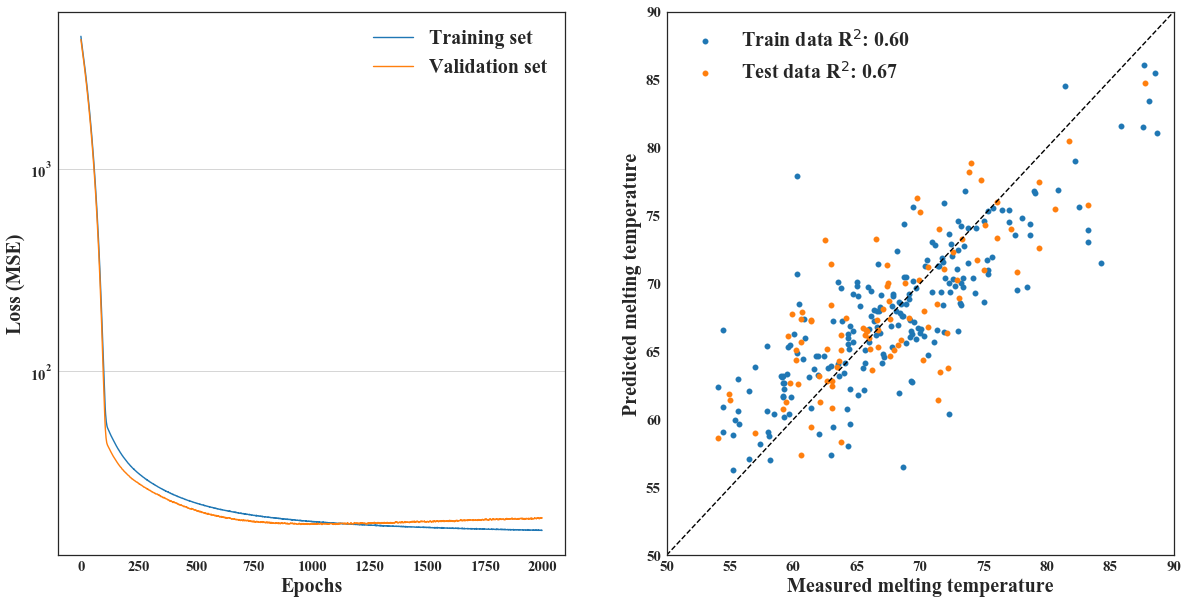

In [51]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 15,
                              'ytick.labelsize': 15, 'legend.fontsize': 20}):
    f, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].semilogy(history.history['loss'], label='Training set')
    ax[0].semilogy(history.history['val_loss'], label='Validation set')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss (MSE)')
    ax[0].grid(axis='y')
    
    ax[1].scatter(y_train, model.predict(X_train), label='Train data R$^2$: {:.2f}'.
                  format(r2_score(y_test, model.predict(X_test))))
    ax[1].scatter(y_test, model.predict(X_test), label='Test data R$^2$: {:.2f}'.
                 format(r2_score(y_train, model.predict(X_train))))
    
    ax[1].plot([50, 90], [50, 90], linestyle='--',c='k')
    
    ax[1].set_ylim(50, 90)
    ax[1].set_xlim(50, 90)

#     ax[1].text(56, 81.2,
#              'Test set R$^2$: {:.2f}'.
#              format(r2_score(y_test, model.predict(X_test))),
#              {'size': 20})
#     ax[1].text(56, 83.2,
#              'Training set R$^2$: {:.2f}'.
#              format(r2_score(y_train, model.predict(X_train))),
#              {'size': 20})
    
    ax[1].legend()
    
    ax[1].set_ylabel('Predicted melting temperature')
    ax[1].set_xlabel('Measured melting temperature')

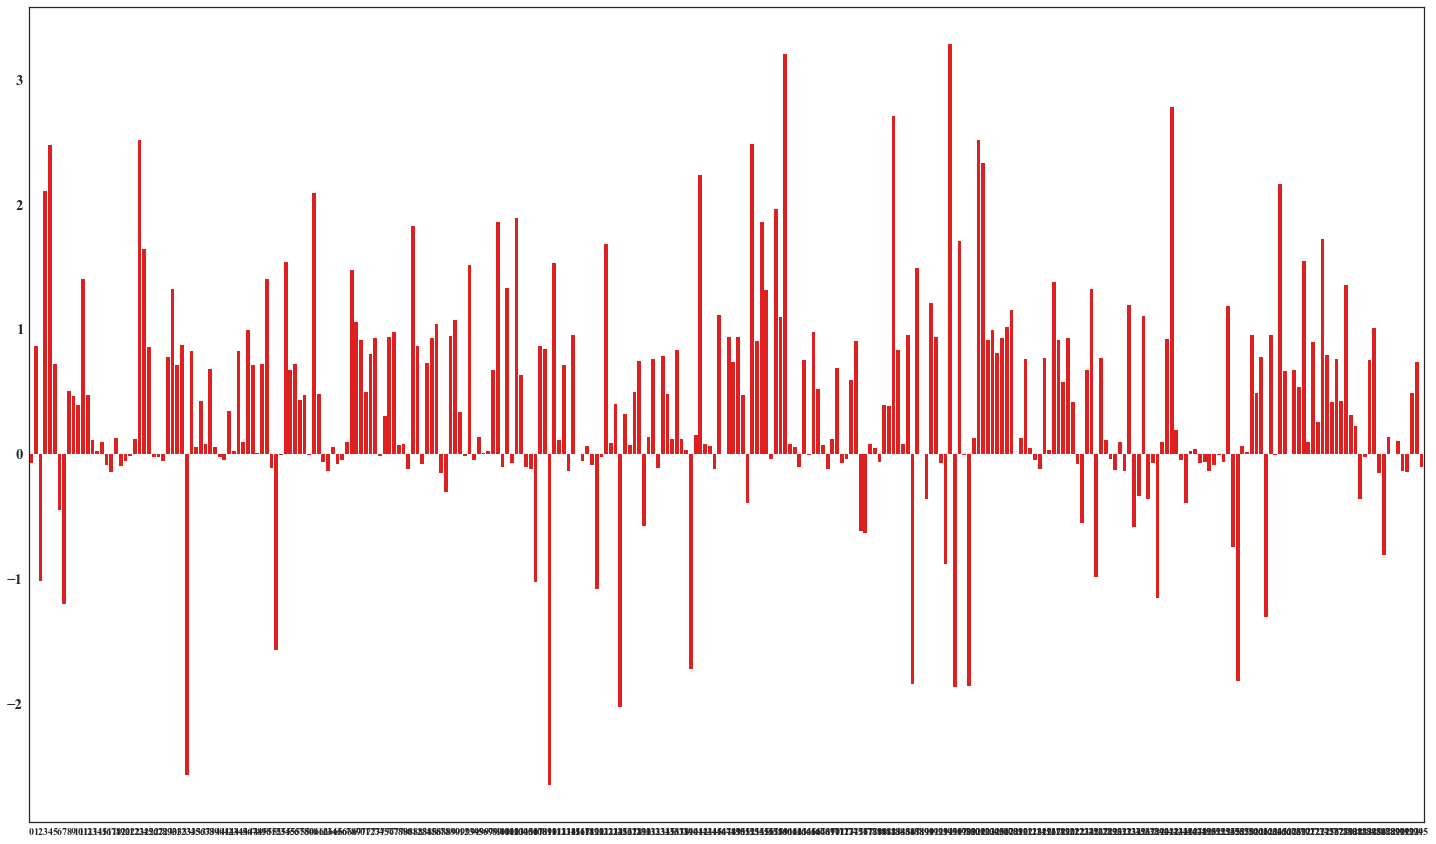

In [52]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 10,
                              'ytick.labelsize': 15, 'legend.fontsize': 15}):
    f, ax = plt.subplots(1, 1, figsize=(25, 15))
    sns.barplot(list(range(len(model.layers[0].get_weights()[0]))), model.layers[0].get_weights()[0].reshape(-1),
                color='r')